In [1]:
import os
import torch
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_drift
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_1d_scan

from bmadx.plot import plot_projections
from phase_space_reconstruction.analysis import plot_scan_data, plot_predicted_screens

In [2]:
data_dir = 'data'

In [3]:
# load data:
train_dset = torch.load(os.path.join(data_dir,'train.dset'))
test_dset = torch.load(os.path.join(data_dir,'test.dset'))
print(f'train k shape: {train_dset.k.shape}')
print(f'test img shape: {train_dset.images.shape}')
print(f'train k shape: {test_dset.k.shape}')
print(f'test img shape: {test_dset.images.shape}')


# image bins: 
bins = torch.linspace(-30, 30, train_dset.images.shape[-1])*1e-3

train k shape: torch.Size([7, 3, 1])
test img shape: torch.Size([7, 3, 200, 200])
train k shape: torch.Size([7, 3, 1])
test img shape: torch.Size([7, 3, 200, 200])


image size = 60 x 60 mm
test samples boxed in orange


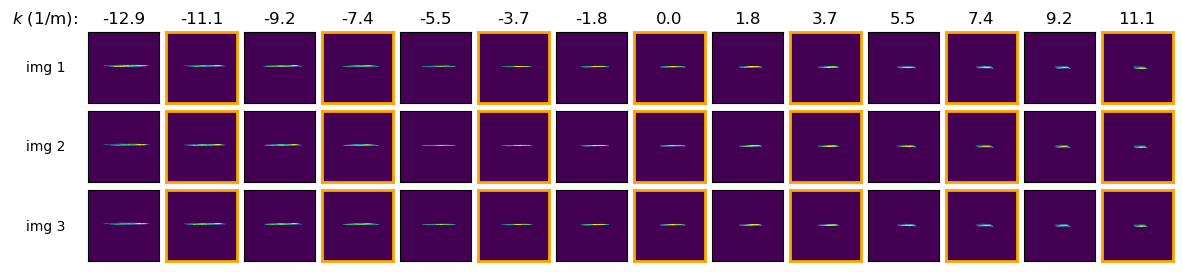

In [4]:
fig, ax = plot_scan_data(train_dset, test_dset, bins)
plt.show()

In [5]:
# diagnostic beamline:
lattice = quad_drift(l_d=1.33 - (0.12/2), l_q=0.12)

# design momentum (eV)
p0c = 43e6

# diagnostic screen: 
bins = torch.linspace(-30, 30, train_dset.images.shape[-1]) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

/home/jp/Repositories/PS-Reconstruction/phase_space_reconstruction/phase_space_reconstruction/diagnostics.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("bandwidth", torch.tensor(bandwidth))


In [6]:
# training
pred_beam = train_1d_scan(train_dset, lattice, p0c, screen, n_epochs=1000, device='cuda')

Using device: cuda


/home/jp/mambaforge/envs/ps-reconstruction/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0 tensor(5000031.5000, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(552622.5000, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(558413.3125, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(416140.0312, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(455960.9375, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(419806.5000, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(442462.6562, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(400321.6250, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(420964.7812, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(406989.7812, device='cuda:0', grad_fn=<MulBackward0>)


In [7]:
# predicted screens:
ks = torch.vstack((train_dset.k, test_dset.k))
pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

image size = 60 x 60 mm
test samples boxed in orange


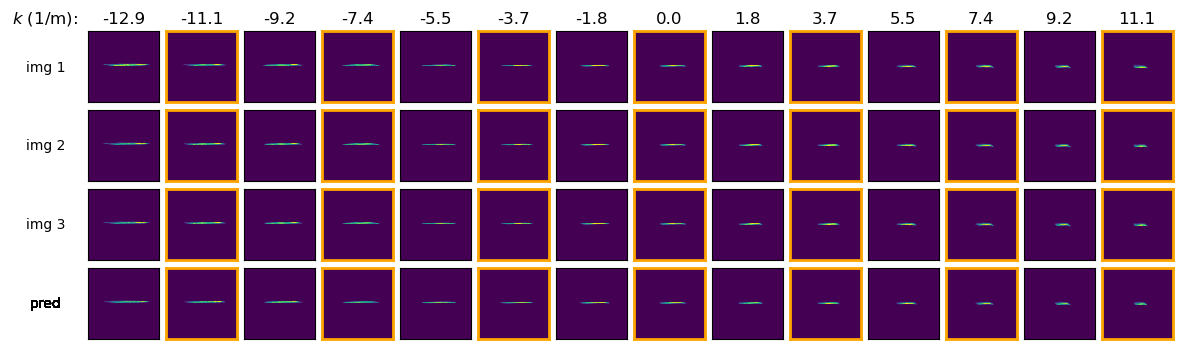

In [8]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins)
plt.show()

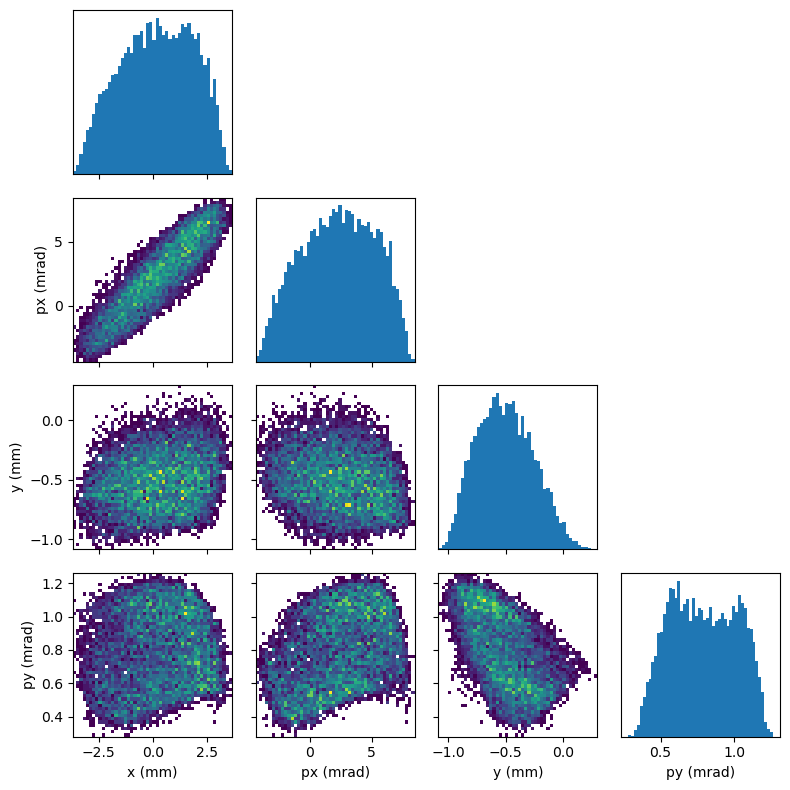

In [9]:
# reconstructed beam projections: 
fig, ax = plot_projections(pred_beam.numpy_particles(),
                           coords=['x', 'px', 'y', 'py'],
                           bins=50,
                           background=False)
plt.show()